In [56]:
# File name friendly
import unicodedata
import re

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

# Assignment 1 - CNN's and VGG16

*In this assingment, you will further familiraize yourself with CNN's and how to implement them. For this particular example, we will ask you to implement the layer structure of VGG16, an old but fairly effective and simple CNN structure.*

*Keep in mind, that while VGG16 and other CNN's you have implemented so far, only incoporate convolutions and pooling layers, many state-of-the-art models  use a variety of other techniques, such as skip connections (CITATION NEEDED), or self-attention (CITATION NEEDED) to get better results.*

*As you write code for this assignment, try to keep in mind to write good code. That might sound vague, but just imagine that some other poor sod will have to read your code at some point, and easily readable, understandable code, will go a long way to making their life easier. However, this is not a coding course, so the main focus should of course be on the exercises themselves.*

**Keep in mind, this assignment does not count towards your final grade in the course. When any of the exercises mention 'grading', it refers to commenting and correcting answers, not necessarily giving you a score which will reflect in your grade, so dw :)**


**Hand-in date is 8/10 at the latest if you want to recieve feedback!!**

## Boilerplate start - you can mostly ignore this!

In [57]:
import os
import gc
import torch
import PIL
from torch import nn
from torch.utils.data.dataloader import default_collate

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

import utils
from datetime import datetime

# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(sum([115, 107, 105, 98, 105, 100, 105, 32, 116, 111, 105, 108, 101, 116]))

torch.cuda.empty_cache()

cuda


In [58]:
# Specify dataset you wanna use
def get_dataset(dataset_name, validation_size=0.1, transform=None, v=True):

    if transform is None:
        transform = ToTensor()

    if dataset_name == 'cifar10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

        # Purely for our convenience - Mapping from cifar labels to human readable classes
        cifar10_classes = {
            0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'
        }

    elif dataset_name == 'mnist':
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

    elif dataset_name == 'imagenette':
        download = not os.path.exists('./data/imagenette2')

        # Specific transform in the case we use imagenette
        imagenette_transform = transforms.Compose([
            transforms.Resize(256),        # Resize to 256x256
            transforms.RandomCrop(224),    # Crop the center to 224x224
            transforms.ToTensor(),         # Convert to tensor
            transforms.Normalize(mean=[0.4650, 0.4553, 0.4258], std=[0.2439, 0.2375, 0.2457]) # Normalize each image, numbers because of function courtesy of chatgpt
        ])
        train_set = datasets.Imagenette(root='./data', split='train', download=download, size='full', transform=imagenette_transform)
        test_set = datasets.Imagenette(root='./data', split='val', download=False, size='full', transform=imagenette_transform)
    
    # If we want a validation set of a given size, take it from train set
    if validation_size is not None:
        # These will both be of the torch.utils.data.Subset type (not the Dataset type), and are basically just mappings of indices
        # This does not matter when we make Dataloaders of them, however
        if dataset_name != 'imagenette':
            train_set, validation_set = torch.utils.data.random_split(train_set, [1-validation_size, validation_size])

        # In the case of imagenette, the 'test set' is already a pretty big validation set, so we'll use that to create the test set instead
        else:
            validation_set, test_set = torch.utils.data.random_split(test_set, [validation_size, 1-validation_size])

    if v:
        print(f"There are {len(train_set)} examples in the training set")
        print(f"There are {len(test_set)} examples in the test set \n")

        print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

    return train_set, validation_set, test_set

# collate function just to cast to device, same as in week_3 exercises
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

## Theoretical questions

*These questions are meant to test your general knowledge of CNN's, feel free to contact or write the TA's if you have any questions about any of them*

### Exercise 1.1

**1. What is the reason we add MaxPooling or AveragePooling in CNN's?**


Pooling reduces the spatial dimensions (width and height) of the input feature maps, which leads to fewer parameters and less computational overhead in the network. This reduction helps in controlling overfitting and makes the model more efficient by compressing the representation.

Max Pooling: Selects the maximum value from each patch of the input feature map. This helps in highlighting the most important (strongest) features in the feature map.

Average Pooling: Computes the average value of each patch in the input feature map. This approach smooths the output and captures the overall average activation in each region.

<img src="Images/pooling.png" alt="Example Image" width="300"/>

**\*2. Say a network comes with a list of class probabilities:** $\hat{p}_1, \hat{p}_2, \dots \hat{p}_N$ **when is the cross-entropy in regards to the *true* class probabilities:** $p_1, p_2, \dots p_N$ **maximized?**

Cross-entropy is a loss function commonly used in classification tasks to measure the difference between two probability distributions: the true distribution and the predicted distribution. The goal of the learning algorithm is to minimize this difference, making the predicted probabilities as close as possible to the true ones.

In the worst-case scenario, the maximum cross-entropy occurs when the predicted distribution is as far away as possible from the true distribution. 

Mathematically, the cross-entropy between a true probability distribution $p$ and a predicted distribution  $\hat{p}$  is maximized when the true class has  $p_{i} = 1$ (i.e., the correct class), and the predicted probability for that class $\hat{p}_{i} = 0$. That is, when the network is completely confident in the wrong class.


**3. In the [VGG paper](https://arxiv.org/pdf/1409.1556), last paragraph of 'training', page 4, they mention images being randomly cropped after being rescaled. Why do you think they crop images only *after* rescaling them?**

Rescaling the images to a range of sizes (in the second approach) ensures that the network can recognize objects at multiple scales. Since objects can appear in different sizes in real-world images, this allows the model to be more robust and adaptable to variations in object size.

After rescaling, random cropping is applied to get the final input size (e.g., 224x224). This firstly serves to prevent  distortion of the objects within the image, and secondly, random cropping introduces variability into the training data, effectively increasing the diversity of the training set. This prevents the model from overfitting to specific object locations within the images.

**4. After this, they mention "further augmenting the dataset" by random horizontal flipping and random RGB color shift. Why do you think they do this?**

The random horizontal flipping helps the model generalize to images with a wider range of orientations, and similarly the RGB color shift trains the model to adapt to different lighting conditions and colors, forcing the weights to prioritize more robust classification features, like shape, texture, and structure.

**\*5. Why do you think they do not randomly translate images? (Translate being to move images left, right, up, down)**

Random translations are not very effective in this context because convolutional layers inherently provide a degree of translation invariance. This is due to the nature of convolution, where the same kernel slides across the image and detects patterns regardless of their exact location.

**6. Which of the following classification tasks do you think is more difficult for a machine learning model, and why?**

- **Telling German Shepherds (Schæferhunde) from Labradors**
- **Telling dogs from cats**
- **Telling horses from cars from totem poles from chainsaws**

We believe telling German shepherds from Labradors is the most difficult tasks among the above, because the features for both classes will be more similar and thus have a greater overlap, making it harder to correctly classify. E.g. the shape of German Shepherds is more similar to Labradors than Dogs are to Cats.


**7. In real life, you often find that neural networks aren't used "for everything", older and often more simple models like random forest and linear regression still dominate a lot of fields.**

- **Reason a bit about why this is the case**

**In terms of reliability:** Using NN (Neural Network) depends on specific settings, meaning a large amount of data is required to build an effective model. In contrast, simpler models can capture trends without needing the complexity of a NN. Interestingly, with NN, you can completely misinterpret the underlying problem but still create an effective model with a large amount of data. Additionally, understanding a problem will always make it easier to implement a much simpler solution. Neural networks are also very sensitive to noise, whereas simpler models are typically more robust against such noise. 

**Resources:** When the large amount of data isn't available, you have to gather it yourself, this can be very pricy, whereas it's easier to build a simple model. Training a good model can also require significant computational resources, but when you can't borrow such powerful machinery, the cost is very high for something you probably only use for one project.

**\*8. When we sample from our dataloader, we sample in batches, why is this? What would be the alternatives to sampling in batches, and what impact would that have?**

When training a neural network, we pass the data through the network multiple times to adjust the weights, and a full pass through the training data is called an epoch. However, when the dataset is too large to fit into memory at once, we divide the data into smaller subsets called batches. The batch size represents the number of training samples in each subset (or batch) processed at a time.

If we don’t use batches, there are two alternatives: processing the data either one sample at a time (Stochastic Gradient Descent) or using the entire dataset in a single update (Full Batch Gradient Descent). Here’s what would happen in each case:

**Stochastic Gradient Descent:**

If we pass one sample at a time through the network (i.e., use a batch size of 1), the model’s weights will be updated after each individual data point. This leads to highly variable gradient updates, which may cause the model’s loss to fluctuate greatly and converge more slowly.

**Full Batch Gradient Descent:**

If we try to feed the entire dataset into the network at once, especially with very large datasets, the large context window would likely use in excess of the available memory (either CPU or GPU). This could cause out-of-memory errors or severely limit the size of datasets we can use for training.


**9. The VGG16-D conv layers all use the same kernel size. Come up with reasons for why you would use bigger/smaller kernel sizes**

The selection of a kernel size depends on the goal in mind. In example, if you want to create an object detection model and you want to capture a car in whole as an object, you would generally use a larger kernel size, but if you wanted to capture the components of the car, you would use a smaller kernel size to e.g. capture the mirror or the wheels' features.

**\*10. The "new kid on the block' (relatively speaking) in NLP (Natural Language processing), is self-attention. Basically this is letting each word/token relate to each other word/token by a specific 'attention' value, vaguely showing how much they relate to one another.**

- **Would there be any problems in doing this for image processing by simply letting each pixel relate to each other pixel, so we can get spatial information that way instead?**

When applying self-attention in image processing, this would entail computing an attention score for each pair of pixels, enabling the model to capture dependencies, regardless of their distance in the image.

The main challenge of applying self-attention to every pixel in an image is the quadratic complexity in terms of both computation and memory. Self-attention requires computing pairwise relationships between all pixels, meaning that for an image with $N$ pixels, you would need to compute $N \times N$ attention scores.

## Boilerplate end - Your implementation work begins here:

*Below, you are given a working example of a CNN, not much different from the one in the exercises of week 3. Your job is to complete the implementation questions below. *

*You do not need to do all the exercises below, or even do them in order, we will obviously only grade the ones you have done, however. Please just mark completed exercises with an X as shown below, so we will know what to look for when grading your assignment. You can add as much text below each question as you want to either argue for your choice of implementation, discuss your results, or ask us questions, we will consider this when grading the assignment.*

**X 0. This marks a question which has been completed**

*For your convenience, we reccommend implementing two models: One bigger for the VGG16-D exercises, meant to be used only with images from the Imagenette dataset, and one smaller, which can also take the other datasets. The model already implemented below should fill the role of the latter.*

*Finally, if you're not able to train the VGG16-D model because it is too big, you can also load the weights of the model using the funciton implemented for exactly that. We do, however, reccommend training it from scratch yourself, if possible.*

______________________________________________________________________________________________

#### **Question from us: We are unsure what is meant by "You do not need to do all the exercises below", is this not relevant for the exam?**


X **1. Implement the layer structure of VGG16-D by following either this [Medium article](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918) (fairly easy), or the [official paper](https://arxiv.org/pdf/1409.1556) (slightly harder) (Note: This layer structure is meant to be used with 224x224 sized images, only the  imagenette dataset in this notebook has this)**

X ****2. Figure out, and implement the type, and exact settings of the optimizer the original VGG16-D implementation used**  
- Batch size: $256$
- **Momentum: $0.9$**
- **$L_2$ Penalty Multiplier: $5\times 10^{-4}$**
- Dropout ratio: $0.5$
- **Learning rate: $10^{-2}$, but decreased by a factor of 10 everytime the validation set accuracy stopped improving (done 3 times in the original VGG16).**
- Epochs: 74 (We set ours to 20)  


We did this by using SGD, but our accuracy was terrible at a 10%, and overfitting highly increased, although, we didn't implement the $L_2$ Penalty Multiplier. so we lowered our Batch size to 64 (mostly due to memory issues - even on HPC with 40 GB VRAM, but this could be due to others using parts of the GPU). We also changed back to Adam optimizer, since this would save us time from manually adjusting momentum and weight decay. Lastly, we decreased the learning rate to $10^{-4}$, and while we tested with the scheduler: "ReduceLROnPlateau", meant to mimic the learning rate factor decrease, we didn't see any improvement in accuracy.
![Optimizer settings](models/settings.png "Optimizer settings")

As seen on the plot, the amount of accuracy data points is significantly reduced with their settings, due to the high batch size of 256 yielding around 4 data points per epoch. However, if we wanted more datapoints, we could use the original dataset "ImageNet", which contains a 100 times more classes, with around 1000 images per class (like Imagenette).

**3.** 
- **Can you make the VGG16-D model overfit to the imagenette dataset? If not, what about another dataset?**
    - Remove dropout layers
    - Increase amount of epochs with a low batch size.  

    As seen on our previous picture, using their optimizer settings, the model was highly overfitted. We conclude this based on the difference in training and testing accuracy.

- **Can you change the amount of dropout to increase or decrease the rate of overfitting?**
    - Yes, if you increase dropout layers you decrease overfitting, by minimizing the amount of weight that's put on to a single neuron, by randomly dropping (set to zero) a certain percentage of neurons in a layer during each training pass, forcing the network to learn more robust features and preventing it from relying too heavily on specific neurons or paths.


- **Can you make the smaller model overfit to any of its datasets? Is it harder or easier? Explain your answer**

**4. Try to improve the test accuracy of either of your models by changing some of they hyperparameters. To make it easier, try to keep detailed results of your experimental setups and your preliminary results. Argue for your changes. Examples of possible changes are shown below:**:
- **Add more/fewer kernels**
- **Add more/less dropout**
- **Add [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)**
- **Change the intial transform when loading the data to make larger/smaller images**

**5. Change the model (or any other code in the whole script) to make either training, inference, or both, as quick as possible, while still keeping a reasonable test accuracy. What did you do to achieve this?**

- The model using batch size 64 and 20 epochs managed to get a 74% accuracy, while being computationally light in both training and inference. Notably we also ran the model using the same hyperparameters but with a batch size of 128, and here we got a 72% accuracy after 20 epochs, which implies no significant difference. Therefor, we found the model with smaller batch size preferable, since it runs faster.



**6. During evaluation, extract some images which were not correctly classified, plot these images and reason about what made them hard-to-classify**

In [59]:
# Get data
train_set, validation_set, test_set = get_dataset('imagenette', validation_size=0.1)

# Make dataloaders
batch_size=64 # Dramatically increases training time
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

There are 9469 examples in the training set
There are 3532 examples in the test set 

Image shape is: torch.Size([3, 224, 224]), label example is 0


In [60]:
class VGG16D(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, features_fore_linear=512*7*7, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = 1
        pool_stride = 2
        conv_kernel = 3
        pool_kernel = 2
        dropout_probs = 0.5
        optim_momentum = 0.9
        weight_decay = 5*10**(-4)
        learning_rate = 0.0001 # Initially set to 0.01 but then decreased by $\times 0.1$ for every plateau

        # Define features and classifier each individually, this is how the VGG16-D model is originally defined
        self.features = torch.nn.Sequential(
            # Conv Block 1
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride), # Image size: 224 -> 112

            # Conv Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride), # Image size: 112 -> 56

            # Conv Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride), # Image size: 56 -> 28

            # Conv Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride), # Image size: 28 -> 14

            # Conv Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride), # Image size: 14 -> 7
            nn.Flatten(),

        ).to(device)
        self.classifier = torch.nn.Sequential(
            # FCL Block 6
            nn.Linear(in_features=features_fore_linear, out_features=4096), # The same as dense layer
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=4096, out_features=num_classes),
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        # Softmax
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate)
        # self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        # Learning rate scheduler for improved convergence
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=10, gamma=0.1)
        # Use a scheduler like VGG16
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, mode='max', factor=0.1, patience=5, verbose=True)

        self.dataset = dataset

    def forward(self, x):
        return self.classifier(self.features(x))

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad(set_to_none=True)

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifications = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifications.append(classification)
            labels.append(label)
            images.append(img)

        return classifications, labels, images

In [61]:
class VGG16S(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=512*7*7, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = ...
        pool_stride = ...
        conv_kernel = ...
        pool_kernel = ...
        dropout_probs = ...
        optim_momentum = ...
        weight_decay = ...
        learning_rate = ...

        # Define features and classifier each individually, this is how the VGG16-D model is originally defined
        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
        ).to(device)
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=features_fore_linear, out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=num_classes)
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=0.001)
        # self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        return self.classifier(self.features(x))

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifications = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifications.append(classification)
            labels.append(label)
            images.append(img)

        return classifications, labels, images

In [62]:
# Pre-trained model
def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model
    Also sets training to only the classifier
    """
    # Load the complete VGG16 model
    temp = torchvision.models.vgg16(weights='DEFAULT')

    # Get its state dict
    state_dict = temp.state_dict()

    # Change the last layer to fit our, smaller network
    state_dict['classifier.6.weight'] = torch.randn(10, 4096)
    state_dict['classifier.6.bias'] = torch.randn(10)

    # Apply the state dict and set the classifer (layer part) to be the only thing we train
    model.load_state_dict(state_dict)

    for param in model.features.parameters():
        param.requires_grad = False

    model.optim = torch.optim.Adam(model.classifier.parameters())


    return model

In [63]:
# in_channels = next(iter(train_dataloader))[0].shape[1]
# in_width_height = next(iter(train_dataloader))[0].shape[-1]
# # Make a dummy model to find out the size before the first linear layer
# CNN_model = VGG16S(num_classes=10, in_channels=in_channels)

# # WARNING - THIS PART MIGHT BREAK
# features_fore_linear = utils.get_dim_before_first_linear(CNN_model.features, in_width_height, in_channels, brain=True)

# # Now make true model when we know how many features we have before the first linear layer
# CNN_model = VGG16S(num_classes=10, in_channels=in_channels, features_fore_linear=7*7*512, dataset=test_set) 

# train_epochs = 5
# train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)



In [64]:
# in_channels = next(iter(train_dataloader))[0].shape[1]
# in_width_height = next(iter(train_dataloader))[0].shape[-1]
# Make a dummy model to find out the size before the first linear layer
# CNN_model = VGG16D(num_classes=1000, in_channels=in_channels)

# # WARNING - THIS PART MIGHT BREAK
# features_fore_linear = utils.get_dim_before_first_linear(CNN_model.features, in_width_height, in_channels, brain=True)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = VGG16D(num_classes=10, in_channels=3, features_fore_linear=512*7*7, dataset=test_set)
# CNN_model = VGG16S(num_classes=10, in_channels=3, features_fore_linear=193600, dataset=test_set)

train_epochs = 75
train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)

100%|██████████| 592/592 [01:45<00:00,  5.63it/s]


Epoch 0 validation accuracy: 0.1823329558323896


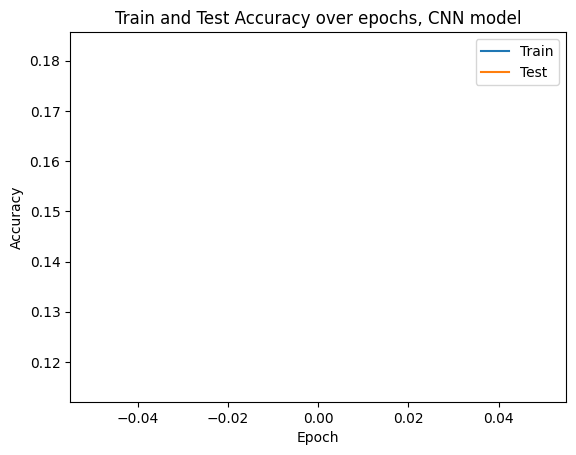

In [65]:
# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
now = datetime.now()
filename = "models/" + slugify(f'{now.date()}_{now.hour}-{now.minute}-{now.second}')
plt.savefig(filename+'.pdf')

In [66]:
def get_incorrect_classifications(model, dataloader):
    """
    Run through the test dataloader and collect incorrectly classified images
    and their respective true and predicted labels.
    """
    model.eval()  # Ensure the model is in evaluation mode
    
    incorrect_images = []
    incorrect_true_labels = []
    incorrect_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in tqdm(dataloader):
            logits = model(inputs)
            predictions = torch.argmax(logits, dim=1)
            incorrect_idx = predictions != labels
            
            # Append only the incorrect classifications
            incorrect_images.extend(inputs[incorrect_idx])
            incorrect_true_labels.extend(labels[incorrect_idx])
            incorrect_predicted_labels.extend(predictions[incorrect_idx])
    
    return incorrect_images, incorrect_true_labels, incorrect_predicted_labels

In [67]:
incorrect_images, incorrect_true_labels, incorrect_predicted_labels = get_incorrect_classifications(CNN_model, test_dataloader)

100%|██████████| 221/221 [00:21<00:00, 10.05it/s]


In [68]:
torch.save(CNN_model, filename+'.pt')

# Clean up to free memory
torch.cuda.empty_cache()
del train_set, validation_set, test_set, train_dataloader, validation_dataloader, test_dataloader, CNN_model
gc.collect()

3311

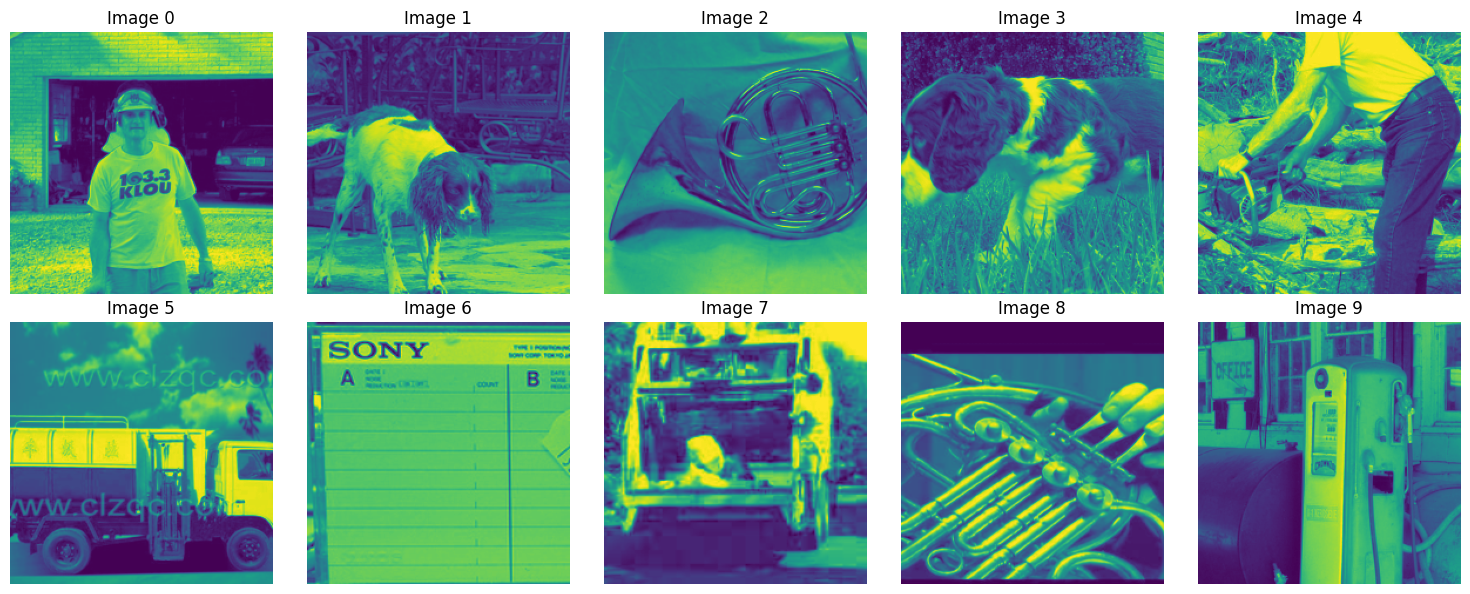

In [70]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    # Calculate the row and column index for the grid
    row, col = divmod(i, 5)
    
    # Access the corresponding image from incorrect_images and plot it
    image = incorrect_images[i][0].cpu().detach().numpy()  # Convert to NumPy array
    axes[row, col].imshow(image, cmap='viridis')  # You can change the colormap if needed
    axes[row, col].axis('off')  # Turn off axis labels for a cleaner look
    axes[row, col].set_title(f"Image {i}")

plt.tight_layout()
plt.savefig(f"Images/incorrect_images_{slugify(f'{now.date()}_{now.hour}-{now.minute}-{now.second}')}.pdf")